## Data

The data is downlodaded from Chip-Atlas.

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
import subprocess
from Bio.SeqRecord import SeqRecord
from random import randint
import math
import itertools
import re
from pyfaidx import Fasta
import argparse
import csv
import os
import random
import sys

/Users/alena/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
plt.style.use('ggplot')

# Generating positive samples

I remove intersecting sequences from the source file so that the same sequences do not fall into train and dev, using bedtools merge


In [3]:
lenght = 300
input_file_name = 'His.ALL.50.H2APERIODZ.AllCell.bed'
name = 'H2AZ'
input_file_sorted = f'{input_file_name}.sorted.bed'

In [4]:
# %%bash
# mkdir tmp_data_files

In [5]:
file1 = open(input_file_name, 'r')
file2 = open('tmp_data_files/1_centered_beds.bed', 'w')

for line in file1:
    l = line.split('\t')
    diff = int(l[2]) - int(l[1])
    b = math.floor((diff - lenght) / 2)
    if diff % 2 == 0:
        print(l[0], int(l[1]) + b, int(l[2]) - b, sep='\t', file=file2)
    else:
        print(l[0], int(l[1]) + b, int(l[2]) - b - 1, sep='\t', file=file2)
        
file1.close()
file2.close()

In [6]:
subprocess.run(f"sort -k1,1 -k2,2n tmp_data_files/1_centered_beds.bed > tmp_data_files/H2AZ.sorted.bed", shell=True)

CompletedProcess(args='sort -k1,1 -k2,2n tmp_data_files/1_centered_beds.bed > tmp_data_files/H2AZ.sorted.bed', returncode=0)

In [7]:
subprocess.run(f"bedtools merge -i tmp_data_files/H2AZ.sorted.bed > tmp_data_files/2_no_overlap.bed -c 1 -o count", shell=True)

CompletedProcess(args='bedtools merge -i tmp_data_files/H2AZ.sorted.bed > tmp_data_files/2_no_overlap.bed -c 1 -o count', returncode=1)

## EDA

Then I explore the lengths of ChIP seq data

In [8]:
%%bash
awk '{print($3-$2)}' tmp_data_files/2_no_overlap.bed  > tmp_data_files/lengths.txt

In [9]:
df = pd.read_csv('tmp_data_files/lengths.txt', 
                  names=['lengths'])

In [10]:
df.shape

(18154, 1)

In [11]:
df.min()[0], df.max()[0]

(300, 1682)

In [12]:
df.median()[0], df.mean()[0]

(334.0, 403.6037236972568)

In [13]:
df.std()

lengths    152.832938
dtype: float64

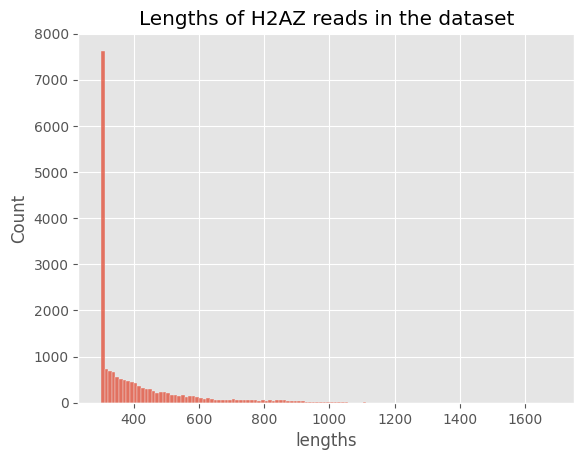

In [14]:
sns.histplot(data=df, x='lengths').set(title=f'Lengths of {name} reads in the dataset')
plt.show()
#plt.savefig('save_as_a_png.eps')

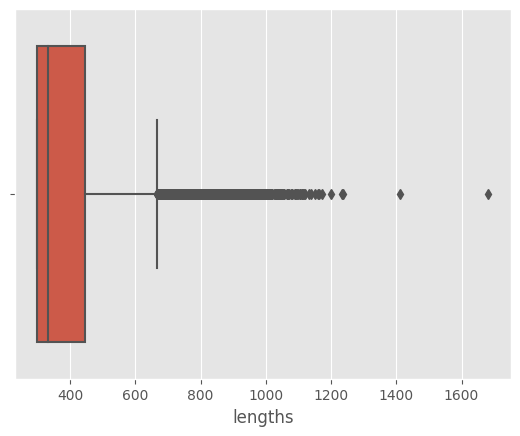

In [15]:
sns.boxplot(data=df, x='lengths')
plt.show()

## Centering

In [16]:
file1 = open('tmp_data_files/2_no_overlap.bed', 'r')
file2 = open('tmp_data_files/3_centered_beds.bed', 'w')

for line in file1:
    l = line.split('\t')
    diff = int(l[2]) - int(l[1])
    b = math.floor((diff - lenght) / 2)
    if diff % 2 == 0:
        print(l[0], int(l[1]) + b, int(l[2]) - b, sep='\t', file=file2)
    else:
        print(l[0], int(l[1]) + b, int(l[2]) - b - 1, sep='\t', file=file2)
        
file1.close()
file2.close()

## Converting to fasta

In [17]:
%%bash
bedtools getfasta -fi genome_files/mm10.fa -bed tmp_data_files/3_centered_beds.bed -fo tmp_data_files/4_centered_fasta.fasta

## Drop unneeded elements

In [18]:
%%bash
awk '!/>/ {print}' tmp_data_files/4_centered_fasta.fasta > tmp_data_files/5_centered_fasta_wo.fasta

In [19]:
%%bash
awk '!/N/ {print}' tmp_data_files/5_centered_fasta_wo.fasta > tmp_data_files/6_centered_fasta_wo_N.fasta

## Upper letters

In [26]:
%%bash
awk '{print toupper($0)}' tmp_data_files/6_centered_fasta_wo_N.fasta > tmp_data_files/7_final_positive_fasta.fasta

In [27]:
%%bash
wc -l < tmp_data_files/7_final_positive_fasta.fasta

   18144


In [28]:
subprocess.run(f"sort -k1,1 -k2,2n tmp_data_files/7_final_positive_fasta.fasta > tmp_data_files/8_final_positive_fasta.fasta", shell=True)

CompletedProcess(args='sort -k1,1 -k2,2n tmp_data_files/7_final_positive_fasta.fasta > tmp_data_files/8_final_positive_fasta.fasta', returncode=0)

In [29]:
output = subprocess.check_output("wc -l < tmp_data_files/8_final_positive_fasta.fasta", shell=True)
number_of_positive_sequences = int(output.decode("utf-8").split()[0])

In [30]:
number_of_positive_sequences

18144

## Generate negative samples

## 1. From genome

Take the subset from genome. Mask overlapped fragment

In [32]:
%%bash
bedtools maskfasta -fi genome_files/mm10.fa -bed His.ALL.50.H2APERIODZ.AllCell.bed -fo genome_files/masked_mm10.fa -mc X

Drop >chr

In [33]:
%%bash
awk '!/>/ {print}' genome_files/masked_mm10.fa > genome_files/joint_mm10.fasta

Add the first line >hg38

In [34]:
%%bash
awk 'NR==1{$0=">mm10"RS$0}7' genome_files/joint_mm10.fasta > genome_files/2_joint_mm10.fasta

Cut random pieces from hg38

In [35]:
record = SeqIO.read('genome_files/2_joint_mm10.fasta', 'fasta')

In [36]:
frags = []
limit = len(record.seq)
for i in range(0, number_of_positive_sequences + 3000): 
    start = randint(0, limit - lenght)
    end = start + lenght
    frag = record.seq[start:end]
    seqrecord = SeqRecord(frag, "fragment_%i" % (i + 1), "", "")
    frags.append(seqrecord)

SeqIO.write(frags, 'tmp_data_files/negseq.fasta', 'fasta-2line')

21144

To upper

In [37]:
%%bash
awk '{print toupper($0)}' tmp_data_files/negseq.fasta > tmp_data_files/negseq_1.fasta

Drop fragements with N and X and >

In [38]:
%%bash
awk '!/>/ {print}' tmp_data_files/negseq_1.fasta > tmp_data_files/negseq_2.fasta

In [39]:
%%bash
awk '!/X/ {print}' tmp_data_files/negseq_2.fasta > tmp_data_files/negseq_3.fasta

In [40]:
%%bash
awk '!/N/ {print}' tmp_data_files/negseq_3.fasta > tmp_data_files/negseq_4.fasta

Balance classes. I cut the file with negative sequences to the number of positive ones

In [41]:
subprocess.run(f"awk '{{print $0}} NR=={number_of_positive_sequences}{{exit}}' tmp_data_files/negseq_4.fasta > tmp_data_files/neg_seq_final_5.fasta", shell=True)

CompletedProcess(args="awk '{print $0} NR==18144{exit}' tmp_data_files/negseq_4.fasta > tmp_data_files/neg_seq_final_5.fasta", returncode=0)

## Preparing final files

In [42]:
def save_txt(seq_list, new_filepath):
    with open(new_filepath, "w") as f:
        f.write("\n".join(seq_list))


def read_txt(filepath):
    with open(filepath) as f:
        seq_list = f.read().splitlines()
    return seq_list

In [43]:
def get_kmer_sentence(original_string, kmer=1, stride=1):
    """
    Convert to kmer format for DNABERT 
    """
    if kmer == -1:
        return original_string

    sentence = ""
    original_string = original_string.replace("\n", "")
    i = 0
    while i < len(original_string) - kmer:
        sentence += original_string[i : i + kmer] + " "
        i += stride

    return sentence[:-1].strip('"')

In [44]:
def write_file(lines, path, kmer=6, head=True, seq_index=0, label_index=1):
    """
    It takes a list of lists, where each list is a line of a file, and writes it to a file
    
    :param lines: the lines to write to the file
    :param path: the path to the file you want to write to
    :param kmer: the length of the k-mer. If kmer is 0, then the whole sequence is used
    :param head: whether to write the header or not, defaults to True (optional)
    :param seq_index: the index of the sequence in the line, defaults to 0 (optional)
    :param label_index: the index of the label in the line, defaults to 1 (optional)
    """
    with open(path, "wt") as f:
        tsv_w = csv.writer(f, delimiter="\t")
        if head:
            tsv_w.writerow(["sentence", "label"])
        for line in lines:
            if kmer == 0:
                sentence = str(line[seq_index])
            else:
                sentence = str(get_kmer_sentence("".join(line[seq_index].split()), kmer))
            if label_index is None:
                label = "0"
            else:
                label = str(line[label_index])
            tsv_w.writerow([sentence, label])

In [45]:
def Generate_prom_train_dev(neg_seq, pos_seq, valtest_percentage):

    seq = read_txt(neg_seq)
    n_neg_seq = len(seq)
    seq = seq + read_txt(pos_seq)
    seq_lbl = [0] * n_neg_seq + [1] * (len(seq) - n_neg_seq)
    seq = [list(x) for x in zip(seq, seq_lbl)]

    # shuffle all the data and split them
    random.shuffle(seq)
    num_seq_test = int(len(seq) * float(valtest_percentage))
    val_lines = seq[:num_seq_test]
    train_lines = seq[num_seq_test:] 
    
    # Save the files
    write_file(train_lines, "train.tsv")
    write_file(val_lines, "dev.tsv")
    #write_file(test_lines, "test.tsv")

Whole genome

In [46]:
neg_seq = 'tmp_data_files/neg_seq_final_5.fasta'
pos_seq = 'tmp_data_files/7_final_positive_fasta.fasta'
Generate_prom_train_dev(neg_seq, pos_seq, 0.2)

In [47]:
train_number = subprocess.check_output("wc -l < train.tsv", shell=True)
train_number = int(train_number.decode("utf-8").split()[0])
dev_number = subprocess.check_output("wc -l < dev.tsv", shell=True)
dev_number = int(dev_number.decode("utf-8").split()[0])
print(f'Number of sequences in train {train_number}, Number of sequences in dev {dev_number}')

Number of sequences in train 29032, Number of sequences in dev 7258
